# Player match history
We add columns to sets_df that track the player vs player history. The values are stored in arrays that have a 1 in the first position if player 1 won the most recent game and a 0 if player 2 won the most recent game, the second value corresponds to the second most recent game, ect. For each set, we only look at results from the previous week or earlier.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import datetime 

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, cohen_kappa_score
from sklearn.model_selection import train_test_split  # Correct import

import sqlite3
import sys
import time
import tqdm
from tqdm.auto import tqdm
import pickle
import joblib
import os

if os.path.exists('/workspace/data'):
    # Load the dictionary of DataFrames from the pickle
    data_path = '/workspace/data/'
else:
    data_path = '../data/'


### Load Data


In [2]:
sets_df = pd.read_pickle(data_path + '/labelled_data/sets_df_3.pkl')
sets_df.head(3)



,key,game,tournament_key,tournament_start_date,winner_id,loser_id,p1_id,p2_id,p1_score,p2_score,...,top_8,top_8_location_names,valid_top_8_bracket,top_8_bracket_location_names,major,ranking_date_index,charcter_data,charcter_change,p1_characters,p2_characters
0,104675843,melee,mdva-invitational-2017-(challonge-mirror),2017-11-26 08:05:11,5620,Chillin,5620,Chillin,3,1,...,False,,False,,False,151.0,False,None,None,None
1,104675844,melee,mdva-invitational-2017-(challonge-mirror),2017-11-26 08:05:11,Aglet,15634,15634,Aglet,2,3,...,False,,False,,False,151.0,False,None,None,None
2,104675845,melee,mdva-invitational-2017-(challonge-mirror),2017-11-26 08:05:11,6126,1097,6126,1097,3,0,...,False,,False,,False,151.0,False,None,None,None


Order the players of a set alphabetically so that each pair of players that played a set against each other has only one label. Make a dataframe with information we will need.

In [3]:
players_np = sets_df[['p1_id', 'p2_id']].to_numpy()
players_sort_np = np.sort(players_np)

set_history_df = sets_df[['ranking_date_index','p1_id', 'p2_id', 'winner_id']].copy()
set_history_df['p1/p2'] = [pair[0]+'/'+pair[1] for pair in players_np]
set_history_df['sort'] = [pair[0]+'/'+pair[1] for pair in players_sort_np]
set_history_df['same'] = (set_history_df['p1/p2'] == set_history_df['sort'])

set_history_df.head()

,ranking_date_index,p1_id,p2_id,winner_id,p1/p2,sort,same
0,151.0,5620,Chillin,5620,5620/Chillin,5620/Chillin,True
1,151.0,15634,Aglet,Aglet,15634/Aglet,15634/Aglet,True
2,151.0,6126,1097,6126,6126/1097,1097/6126,False
3,151.0,Chu,1069,1069,Chu/1069,1069/Chu,False
4,151.0,Jerry,Rishi,Rishi,Jerry/Rishi,Jerry/Rishi,True


In [4]:
set_history_df.sort_values(['ranking_date_index'])
set_history_df.head()

,ranking_date_index,p1_id,p2_id,winner_id,p1/p2,sort,same
0,151.0,5620,Chillin,5620,5620/Chillin,5620/Chillin,True
1,151.0,15634,Aglet,Aglet,15634/Aglet,15634/Aglet,True
2,151.0,6126,1097,6126,6126/1097,1097/6126,False
3,151.0,Chu,1069,1069,Chu/1069,1069/Chu,False
4,151.0,Jerry,Rishi,Rishi,Jerry/Rishi,Jerry/Rishi,True


Filter ``sets_df`` to sets between players who play at least two sets against each other.

In [5]:
counts = set_history_df['sort'].value_counts()
multiple_sets = list(counts[counts > 1].index)
filtered_sets_df = set_history_df[set_history_df['sort'].isin(multiple_sets)]
print(f"There are {filtered_sets_df.shape[0]:,} sets between players who played against each other more than once and make up {filtered_sets_df.shape[0]/sets_df.shape[0]:.0%} of the sets.")
filtered_sets_df.head(5)

There are 824,986 sets between players who played against each other more than once and make up 46% of the sets.


,ranking_date_index,p1_id,p2_id,winner_id,p1/p2,sort,same
2,151.0,6126,1097,6126,6126/1097,1097/6126,False
6,151.0,1069,5620,5620,1069/5620,1069/5620,True
10,151.0,5620,1097,5620,5620/1097,1097/5620,False
19,151.0,15634,6126,15634,15634/6126,15634/6126,True
24,151.0,1069,1097,1097,1069/1097,1069/1097,True


In [ ]:
def compute_results(filtered_sets_df):
    # Ensure the DataFrame is sorted by ranking_date_index for chronological processing
    filtered_sets_df = filtered_sets_df.sort_values(by='ranking_date_index').copy()
    
    # Initialize a dictionary to store the results for each row
    results_dict = {}

    # Group by the 'sort' column
    for _, group_df in tqdm(filtered_sets_df.groupby('sort')):
        # Initialize a list to store past results for this group
        results_so_far = []
        
        # Iterate through the rows of this group
        for idx, row in group_df.iterrows():
            # Determine the winner in terms of p1_id
            if row['same']:
                # If p1_id and p2_id are in alphabetical order
                result = 1 if row['winner_id'] == row['p1_id'] else 0
            else:
                # If p1_id and p2_id are not it alphabetical order
                result = 1 if row['winner_id'] == row['p2_id'] else 0
            
            # Add the results so far for this row
            results_dict[idx] = results_so_far.copy()
            
            # Update the results for future rows
            results_so_far.insert(0, result)  # Add the result to the front (most recent match first)
    
    # Add the results column to the DataFrame
    filtered_sets_df['results_sort'] = filtered_sets_df.index.map(results_dict)
    
    return filtered_sets_df

# Apply the function to your DataFrame
filtered_sets_df = compute_results(filtered_sets_df)

# Convert the 'results' column to a column of NumPy arrays
filtered_sets_df['results_sort'] = filtered_sets_df['results_sort'].apply(np.array)
filtered_sets_df['results'] = filtered_sets_df['results'].copy()

# Swap the 1s and 0s if the order of p1 and p2 are not alphabetical.
filtered_sets_df.loc[(filtered_sets_df['same'] == False), 'results'] = filtered_sets_df.loc[(filtered_sets_df['same'] == False), 'results'].apply(lambda x: 1-x)

# Display the updated DataFrame
filtered_sets_df.head()


  0%|          | 0/223467 [00:00<?, ?it/s]

,ranking_date_index,p1_id,p2_id,winner_id,p1/p2,sort,same,results_sort,results_ordered
804,1.0,19573,6189,6189,19573/6189,19573/6189,True,[],[]
806,1.0,4465,6189,4465,4465/6189,4465/6189,True,[],[]
805,1.0,1000,6189,6189,1000/6189,1000/6189,True,[],[]
801,1.0,12870,5956,5956,12870/5956,12870/5956,True,[],[]
798,1.0,12870,Beat,12870,12870/Beat,12870/Beat,True,[],[]


In [ ]:
top_player_id = {
    'aMSa': '1021',
    'Cody': '19554',
    'Mang0': '1000',
    'Zain': '6126',
    'Armada': '6189',
    'Wizzrobe': '1028',
    'Mew2King': '1003',
    'PPMD': '1002',
    'Hungrybox': '1004',
    'Plup': '15990',
    'Axe': '16342'
}


df

,ranking_date_index,p1_id,p2_id,winner_id,p1/p2,sort,same,results_sort,results_ordered
1217,18.0,1000,1004,1000,1000/1004,1000/1004,True,[],[]
1339,25.0,1004,1000,1000,1004/1000,1000/1004,False,[1],[0]
1912,28.0,1004,1000,1004,1004/1000,1000/1004,False,"[1, 1]","[0, 0]"
116097,39.0,1004,1000,1004,1004/1000,1000/1004,False,"[0, 1, 1]","[1, 0, 0]"
112923,54.0,1004,1000,1000,1004/1000,1000/1004,False,"[0, 0, 1, 1]","[1, 1, 0, 0]"
...,...,...,...,...,...,...,...,...,...
1299338,444.0,1000,1004,1004,1000/1004,1000/1004,True,"[0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, ...","[0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, ..."
1349754,449.0,1000,1004,1004,1000/1004,1000/1004,True,"[0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, ...","[0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, ..."
1613813,476.0,1000,1004,1004,1000/1004,1000/1004,True,"[0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, ...","[0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, ..."
1750435,489.0,1000,1004,1000,1000/1004,1000/1004,True,"[0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, ...","[0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, ..."


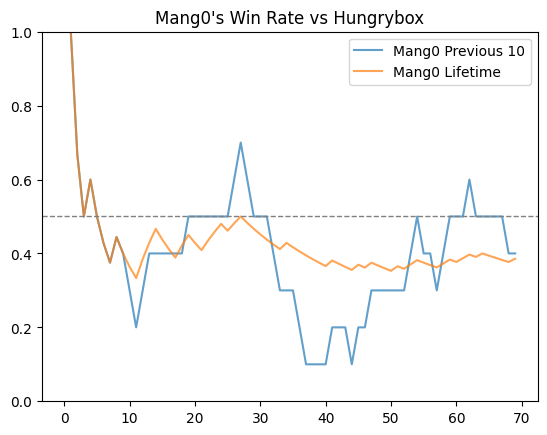

In [ ]:
df = filtered_sets_df[filtered_sets_df['sort'] == (top_player_id['Mang0'] + '/' + top_player_id['Hungrybox'])]

overall = df['results_sort'][1:].apply(lambda x: np.sum(x) / x.shape[0]) 
running = overall.copy()
running[9:] = df['results_sort'][10:].apply(lambda x: np.sum(x[:10]) / 10) 
x = np.arange(0,overall.shape[0])
plt.plot(x, running, label = 'Mang0 Previous 10', alpha=.7)
plt.plot(x, overall, label = 'Mang0 Lifetime', alpha=.7)

plt.ylim([0,1])
# Add a horizontal line at y=0
plt.axhline(y=.5, color='gray', linestyle='--', linewidth=1)
plt.title("Mang0's Win Rate vs Hungrybox")
plt.legend()


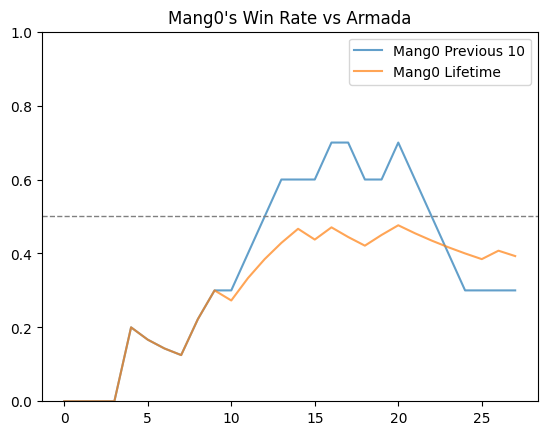

In [71]:
df = filtered_sets_df[filtered_sets_df['sort'] == (top_player_id['Mang0'] + '/' + top_player_id['Armada'])]

overall = df['results_sort'][1:].apply(lambda x: np.sum(x) / x.shape[0]) 
running = overall.copy()
running[9:] = df['results_sort'][10:].apply(lambda x: np.sum(x[:10]) / 10) 
x = np.arange(0,overall.shape[0])
plt.plot(x, running, label = 'Mang0 Previous 10', alpha=.7)
plt.plot(x, overall, label = 'Mang0 Lifetime', alpha=.7)

plt.ylim([0,1])
# Add a horizontal line at y=0
plt.axhline(y=.5, color='gray', linestyle='--', linewidth=1)
plt.title("Mang0's Win Rate vs Armada")
plt.legend()


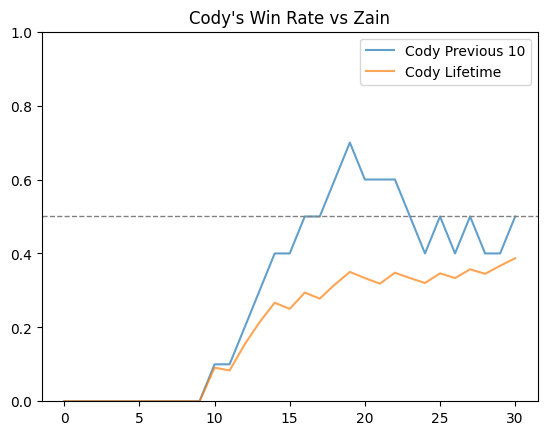

In [73]:
df = filtered_sets_df[filtered_sets_df['sort'] == (top_player_id['Cody'] + '/' + top_player_id['Zain'])]

overall = df['results_sort'][1:].apply(lambda x: np.sum(x) / x.shape[0]) 
running = overall.copy()
running[9:] = df['results_sort'][10:].apply(lambda x: np.sum(x[:10]) / 10) 
x = np.arange(0,overall.shape[0])
plt.plot(x, running, label = 'Cody Previous 10', alpha=.7)
plt.plot(x, overall, label = 'Cody Lifetime', alpha=.7)

plt.ylim([0,1])
# Add a horizontal line at y=0
plt.axhline(y=.5, color='gray', linestyle='--', linewidth=1)
plt.title("Cody's Win Rate vs Zain")
plt.legend()

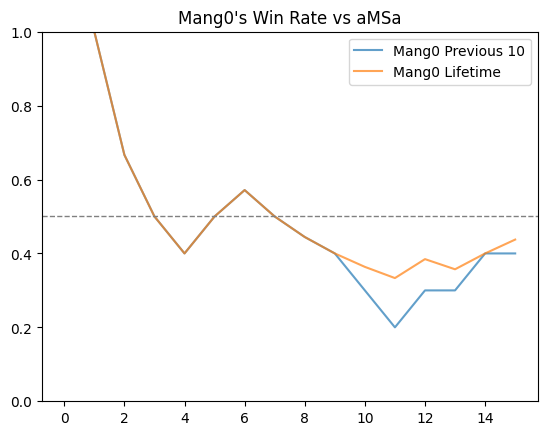

In [75]:
df = filtered_sets_df[filtered_sets_df['sort'] == (top_player_id['Mang0'] + '/' + top_player_id['aMSa'])]

overall = df['results_sort'][1:].apply(lambda x: np.sum(x) / x.shape[0]) 
running = overall.copy()
running[9:] = df['results_sort'][10:].apply(lambda x: np.sum(x[:10]) / 10) 
x = np.arange(0,overall.shape[0])
plt.plot(x, running, label = 'Mang0 Previous 10', alpha=.7)
plt.plot(x, overall, label = 'Mang0 Lifetime', alpha=.7)

plt.ylim([0,1])
# Add a horizontal line at y=0
plt.axhline(y=.5, color='gray', linestyle='--', linewidth=1)
plt.title("Mang0's Win Rate vs aMSa")
plt.legend()